# XGBoost for Classification

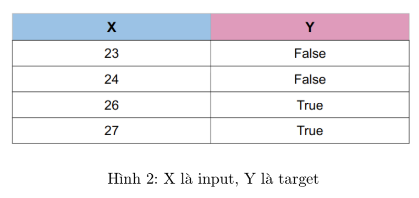

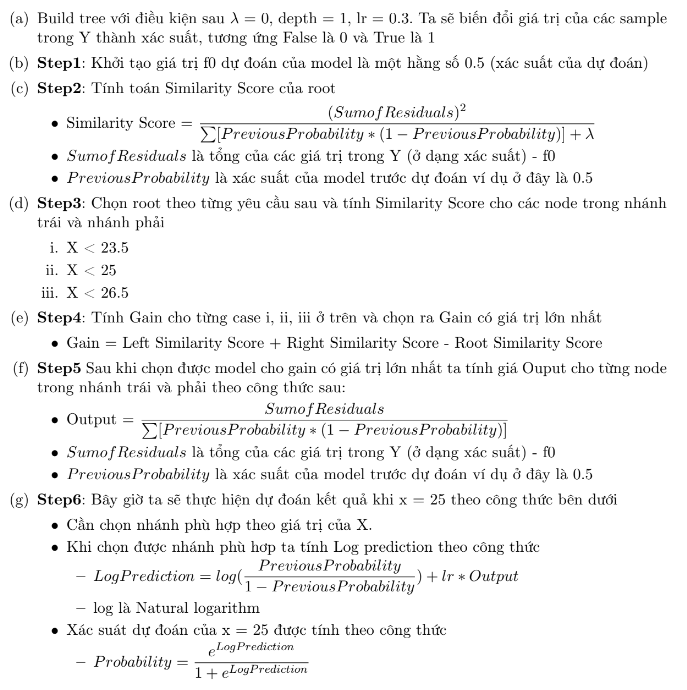

In [8]:
import numpy as np
import math

def cal_similarity_score_classification(arr_y, pre_probability_y, param_lambda):
  print("arr_y", arr_y)
  print("arr_y - pre_probability_y", arr_y - pre_probability_y)
  sc = np.sum(arr_y - pre_probability_y)**2 / (len(arr_y) * (pre_probability_y * (1 - pre_probability_y)) + param_lambda)
  print("[", arr_y, "], pre_probability_y=", pre_probability_y, ":   sc=", sc)
  return sc

In [9]:
X = np.array([23,24,26,27])
Y = np.array([False,False,True,True])

print("(a) Build tree với điều kiện sau λ = 0, depth = 1, lr = 0.3")
param_lambda = 0
param_depth = 1
param_lr = 0.3
# biến đổi giá trị của các sample trong Y thành xác suất, tương ứng False là 0 và True là 1
Y = np.array([0 if y == False else 1 for y in Y])

print("(b) Step1: Khởi tạo giá trị f0 dự đoán của model là một hằng số 0.5 (xác suất của dự đoán)")
f0 = 0.5
print("f0: ", f0)

print("(c) Step2: Tính toán Similarity Score của root")
similarity_score_root = cal_similarity_score_classification(Y, f0, param_lambda)
print("similarity_score_root: ", similarity_score_root)
max_gain = 0
root_node = 0
print("(d) Step3: Chọn root theo từng yêu cầu sau và tính Similarity Score cho các node trong nhánh trái và nhánh phải")
for i in np.array([23.5, 25, 26.5]):
  print("-----------------------")
  print("X < ", i)
  left_array = Y[X < i]
  right_array = Y[X >= i]
  similarity_score_left = cal_similarity_score_classification(left_array, f0, param_lambda)
  similarity_score_right = cal_similarity_score_classification(right_array, f0, param_lambda)

  print("(e) Step4: Tính Gain cho từng case i, ii, iii ở trên và chọn ra Gain có giá trị lớn nhất")
  gain = similarity_score_left + similarity_score_right - similarity_score_root
  print("gain: ", gain)
  if gain > max_gain:
    max_gain = gain
    root_node = i

print("\n\nmax gain: ", max_gain)
print("root_node: ", root_node)
print("(f) Step5 Sau khi chọn được model cho gain có giá trị lớn nhất ta tính giá Ouput cho từng node trong nhánh trái và phải")
output_left = np.sum(Y[X < root_node] - f0) / (f0 * (1 - f0))
output_right = np.sum(Y[X >= root_node] - f0) / (f0 * (1 - f0))
print("output_left: ", output_left)
print("output_right: ", output_right)

x = 25
print("(g) Step6: Bây giờ ta sẽ thực hiện dự đoán kết quả khi x = 25 theo công thức bên dưới")
output = output_left if x < root_node else output_right
log_prediction = math.log(f0 / (1-f0)) + param_lr * output
output_probability = math.exp(log_prediction) / (1 + math.exp(log_prediction))
print("output: ", output_probability)

(a) Build tree với điều kiện sau λ = 0, depth = 1, lr = 0.3
(b) Step1: Khởi tạo giá trị f0 dự đoán của model là một hằng số 0.5 (xác suất của dự đoán)
f0:  0.5
(c) Step2: Tính toán Similarity Score của root
arr_y [0 0 1 1]
arr_y - pre_probability_y [-0.5 -0.5  0.5  0.5]
[ [0 0 1 1] ], pre_probability_y= 0.5 :   sc= 0.0
similarity_score_root:  0.0
(d) Step3: Chọn root theo từng yêu cầu sau và tính Similarity Score cho các node trong nhánh trái và nhánh phải
-----------------------
X <  23.5
arr_y [0]
arr_y - pre_probability_y [-0.5]
[ [0] ], pre_probability_y= 0.5 :   sc= 1.0
arr_y [0 1 1]
arr_y - pre_probability_y [-0.5  0.5  0.5]
[ [0 1 1] ], pre_probability_y= 0.5 :   sc= 0.3333333333333333
(e) Step4: Tính Gain cho từng case i, ii, iii ở trên và chọn ra Gain có giá trị lớn nhất
gain:  1.3333333333333333
-----------------------
X <  25.0
arr_y [0 0]
arr_y - pre_probability_y [-0.5 -0.5]
[ [0 0] ], pre_probability_y= 0.5 :   sc= 2.0
arr_y [1 1]
arr_y - pre_probability_y [0.5 0.5]
[ [1 

# XGBoost Classifier

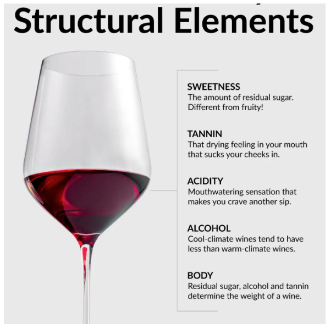

Mục tiêu chính của chúng ta là sử dụng mô hình này để giải quyết một bài toán classification, cụ thể là dự đoán chất lượng của wine (3 classes: 0, 1, 2).

## (a) Import các thư viện cần thiết
Trong đó xgboost là thư viện mà chúng ta sẽ sử dụng để cài đặt và huấn luyện mô hình XGBoost.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## (b) Load data để xử lý và phân tích.
Chúng ta sẽ sử dụng phương thức read_csv() của pandas để đọc dữ liệu từ một tệp .csv.

In [5]:
dataset_path = '/content/Problem4.csv'
data_df = pd.read_csv(dataset_path)
data_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


Trong bài toán dự đoán này, chúng ta quan tâm đến việc dự đoán chất lượng của rượu vang (loại 0, 1, 2) dựa trên một loạt các thuộc tính được cung cấp. Loại chất lượng của rượu vang, được lưu trữ trong cột "Target", ta sẽ gán giá trị từ cột này vào biến y (là cột cuối cùng). Những thuộc tính còn lại sẽ được gán vào biến X.

## (c) Encode data
Trong bộ dữ liệu chỉ chứa các đặc trưng dạng số và không có bất kỳ đặc trưng dạng danh mục (categorical) nào, thì không cần thiết phải thực hiện bước mã hóa (encoding).

## (d) Tách training parameters và label
Vì bài toán của chúng ta là supervised learning nên tập data train cần có input các đặc trưng (X) và target/label (y), do đó ta sẽ tách các cột dữ liệu thành hai biến X, y. Trong bài toán này target/label là 'Target' là loại chất lượng và là cột cuối cùng

In [6]:
X, y = data_df.iloc[:, :-1], data_df.iloc[:, -1]

## (e) Tách tập dữ liệu thành tập train và tập test
Dựa vào bộ dữ liệu gốc, ta cần chia thành hai tập dữ liệu con, một dùng cho việc huấn luyện mô hình và một cho việc đánh giá mô hình. Ở đây, ta sẽ chia theo tỷ lệ 7:3 và tham số ngẫu nhiên random_state = 7:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

## (f) Xây dựng model XGBoost cho Classification
Chúng ta xây dựng model XGBoost cho Classification task với các tham số sau seed=7. Sau đó ta sẽ huấn luyện mô hình với tập data train

In [8]:
xg_class = xgb.XGBClassifier(seed=7)
xg_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## (g) Test mô hình trên tập dữ liệu test
Để đảm bảo mô hình của chúng ta không chỉ hoạt động tốt trên dữ liệu huấn luyện mà còn có khả năng tổng quát hóa tốt trên dữ liệu mới, việc sử dụng một tập test là rất quan trọng. Tập test này sẽ chứa một phần dữ liệu mà mô hình chưa từng thấy trong quá trình huấn luyện. Đầu tiên, ta cho mô hình đã huấn luyện thực hiện dự đoán trên toàn bộ tập test:

In [9]:
preds = xg_class.predict(X_test)

## Sử dụng Accuracy đánh giá mô hình
Đối với bài toán phân loại (Classification), việc đánh giá hiệu suất mô hình thường sử dụng các độ đo khác nhau so với bài toán hồi quy (Regression). Trong bài toán phân loại, "accuracy" là một trong những độ đo cơ bản và phổ biến nhất.

**Accuracy (Độ chính xác)**: Độ chính xác cho biết tỷ lệ mẫu được phân loại đúng trong tất cả các mẫu của tập dữ liệu. Nó được tính bằng cách lấy số mẫu được phân loại đúng chia cho tổng số mẫu.

$Accuracy = \displaystyle\frac{Số mẫu phân loại đúng}{Tổng số mẫu}$

Tuy nhiên, cần lưu ý rằng trong một số trường hợp, đặc biệt là khi dữ liệu không cân bằng (một lớp có số lượng mẫu nhiều hơn nhiều so với lớp khác), độ chính xác không phản ánh đúng hiệu suất của mô hình. Trong những trường hợp như vậy, chúng ta cần xem xét các độ đo khác như Precision, Recall, F1-score, ROC, AUC, vv.

Nhưng nếu bạn chỉ muốn một cái nhìn tổng quan và đơn giản về hiệu suất mô hình, thì accuracy là một lựa chọn tốt để bắt đầu.

In [10]:
train_acc = accuracy_score(y_train, xg_class.predict(X_train))
test_acc = accuracy_score(y_test, preds)

print(f'Train ACC: {train_acc:.4f}')
print(f'Test ACC: {test_acc:.4f}')

Train ACC: 1.0000
Test ACC: 0.9630
